In [59]:
# numpy and pandas for data manipulation
from logging import warning
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder 

# File system manangement
import os

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#preprocess
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# import metric
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix,plot_roc_curve,roc_curve
from sklearn.metrics import log_loss
#model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier,Pool

#hypertune
from sklearn.model_selection import StratifiedKFold
import hyperopt
from hyperopt import hp, fmin, tpe,Trials,STATUS_OK

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [60]:
app_train=pd.read_csv('application_train.csv')
app_test=pd.read_csv('application_test.csv')
bureau=pd.read_csv('bureau.csv')
bureau_balance=pd.read_csv('bureau_balance.csv')
install_pay=pd.read_csv('installments_payments.csv')
pos_balance=pd.read_csv('POS_CASH_balance.csv')
prev_app=pd.read_csv('previous_application.csv')
sample_sub=pd.read_csv('sample_submission.csv')

# EDA

In [61]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='TARGET'>

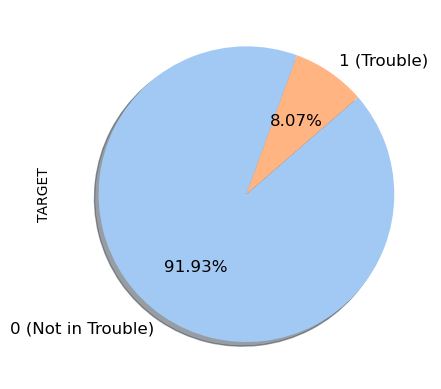

In [62]:
# define Seaborn color palette to use
colors = sns.color_palette('pastel')
  
# plotting data on chart

labels ="0 (Not in Trouble)", "1 (Trouble)"
app_train["TARGET"].value_counts().plot.pie(autopct='%1.2f%%', shadow=True,labels = labels ,colors=colors, fontsize=12, startangle=70)

Our dataset have imbalance Target, this means we can try balance our training data to improve our Machine learning model

## Missing Value

In [63]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [64]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


There are total 67 columns from 122 have null values, and mostly of them have severe missing value. we will continue our EDA to decide what to do with this latter, should we impute it or drop the columns

## Anomalies

### Column Types

In [65]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [66]:
pd.DataFrame(app_train.dtypes).reset_index().style

,index,0
0,SK_ID_CURR,int64
1,TARGET,int64
2,NAME_CONTRACT_TYPE,object
3,CODE_GENDER,object
4,FLAG_OWN_CAR,object
5,FLAG_OWN_REALTY,object
6,CNT_CHILDREN,int64
7,AMT_INCOME_TOTAL,float64
8,AMT_CREDIT,float64
9,AMT_ANNUITY,float64


quick look into the type of columns are normal
* `Flag_Document` columns are categorical feature
 

In [67]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Columns Statistics

#### Float

In [68]:
app_train.select_dtypes('float64').describe().round(2).style

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307499.000000,307233.000000,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,306851.000000,246546.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,168797.920000,599026.000000,27108.570000,538396.210000,0.020000,-4986.120000,12.060000,2.150000,0.500000,0.510000,0.510000,0.120000,0.090000,0.980000,0.750000,0.040000,0.080000,0.150000,0.230000,0.230000,0.070000,0.100000,0.110000,0.010000,0.030000,0.110000,0.090000,0.980000,0.760000,0.040000,0.070000,0.150000,0.220000,0.230000,0.060000,0.110000,0.110000,0.010000,0.030000,0.120000,0.090000,0.980000,0.760000,0.040000,0.080000,0.150000,0.230000,0.230000,0.070000,0.100000,0.110000,0.010000,0.030000,0.100000,1.420000,0.140000,1.410000,0.100000,-962.860000,0.010000,0.010000,0.030000,0.270000,0.270000,1.900000
std,237123.150000,402490.780000,14493.740000,369446.460000,0.010000,3522.890000,11.940000,0.910000,0.210000,0.190000,0.190000,0.110000,0.080000,0.060000,0.110000,0.080000,0.130000,0.100000,0.140000,0.160000,0.080000,0.090000,0.110000,0.050000,0.070000,0.110000,0.080000,0.060000,0.110000,0.070000,0.130000,0.100000,0.140000,0.160000,0.080000,0.100000,0.110000,0.050000,0.070000,0.110000,0.080000,0.060000,0.110000,0.080000,0.130000,0.100000,0.150000,0.160000,0.080000,0.090000,0.110000,0.050000,0.070000,0.110000,2.400000,0.450000,2.380000,0.360000,826.810000,0.080000,0.110000,0.200000,0.920000,0.790000,1.870000
min,25650.000000,45000.000000,1615.500000,40500.000000,0.000000,-24672.000000,0.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,112500.000000,270000.000000,16524.000000

There are indication of anomaly let's check further into this

 ##### Age

In [69]:
(app_train[['DAYS_BIRTH']]/-365).describe()

,DAYS_BIRTH
count,307511.000000
mean,43.936973
std,11.956133
min,20.517808
25%,34.008219
50%,43.150685
75%,53.923288
max,69.120548


`Days_Birth`: column looks normal. min and max someone age is normal, there is not any outliers in data.

##### Days_Employed

In [70]:
(app_train[['DAYS_BIRTH','DAYS_EMPLOYED']]/365).describe()

,DAYS_BIRTH,DAYS_EMPLOYED
count,307511.000000,307511.000000
mean,-43.936973,174.835742
std,11.956133,387.056895
min,-69.120548,-49.073973
25%,-53.923288,-7.561644
50%,-43.150685,-3.323288
75%,-34.008219,-0.791781
max,-20.517808,1000.665753


`Days_Employed`: there is some abnormality going on the data, the max value `DAYS_EMPLOYED` show 1000 YEARS, this is imposible

Lets take a more deep into this

In [71]:
print(len(app_train['DAYS_EMPLOYED'][app_train['DAYS_EMPLOYED'] > 0]))
print(len(app_train['DAYS_EMPLOYED'][app_train['DAYS_EMPLOYED'] == 365243]))

55374
55374


In [72]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous Days_Employed' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous Days_Employed


It turns out that the anomalies have a lower rate of default, and shows that every positive value set to the max level. it could means that loaners who don't employed was set to `365243` on this column.

but for safest route I'm gonna set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (`np.nan`) and then create a new boolean column indicating whether or not the value was anomalous.


Text(0.5, 0, 'Days Employment')

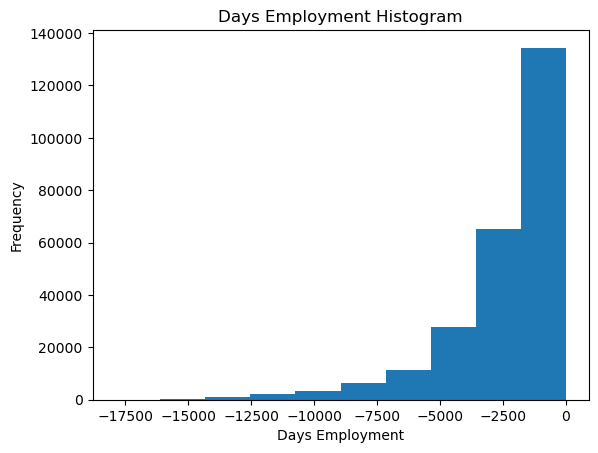

In [73]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [74]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


#### Object

In [75]:
app_train.select_dtypes('object').describe().round(2).style

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


Integer

In [76]:
app_train.select_dtypes('int').describe().round(2).style

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.520000,0.080000,0.420000,-16037.000000,-2994.200000,1.000000,0.820000,0.200000,1.000000,0.280000,0.060000,2.050000,2.030000,12.060000,0.020000,0.050000,0.040000,0.080000,0.230000,0.180000,0.000000,0.710000,0.000000,0.020000,0.090000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000
std,102790.180000,0.270000,0.720000,4363.990000,1509.450000,0.000000,0.380000,0.400000,0.040000,0.450000,0.230000,0.510000,0.500000,3.270000,0.120000,0.220000,0.200000,0.270000,0.420000,0.380000,0.010000,0.450000,0.010000,0.120000,0.280000,0.010000,0.270000,0.060000,0.000000,0.060000,0.000000,0.060000,0.050000,0.030000,0.100000,0.020000,0.090000,0.020000,0.020000,0.020000
min,100002.000000,0.000000,0.000000,-25229.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-19682.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-15750.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-12413.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,-7489.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


everything looks normal, Althought there are several categorical column 

## Correlation

In [77]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


The top three significant positive correlation are `REGION_RATING_CLIENT_W_CITY`, `DAYS_EMPLOYED`, `DAYS_BIRTH`<br> 
The top three significant negative correlation are`EXT_SOURCE_3`,`EXT_SOURCE_2`,`EXT_SOURCE_1`<br>
* `DAYS_BIRTH` column is negative value it means the older someone they are less likely to default on their loan (target == 0).
* `DAYS_EMPLOYED` column is negative value it means the older they are employed at current job (relative to application) they are less likely to deault on their loan(target == 0).
* `REGION_RATING_CLIENT_W_CITY` The column rate the region including city where client live, showing the more higher score where client live the are likely to default on their loan

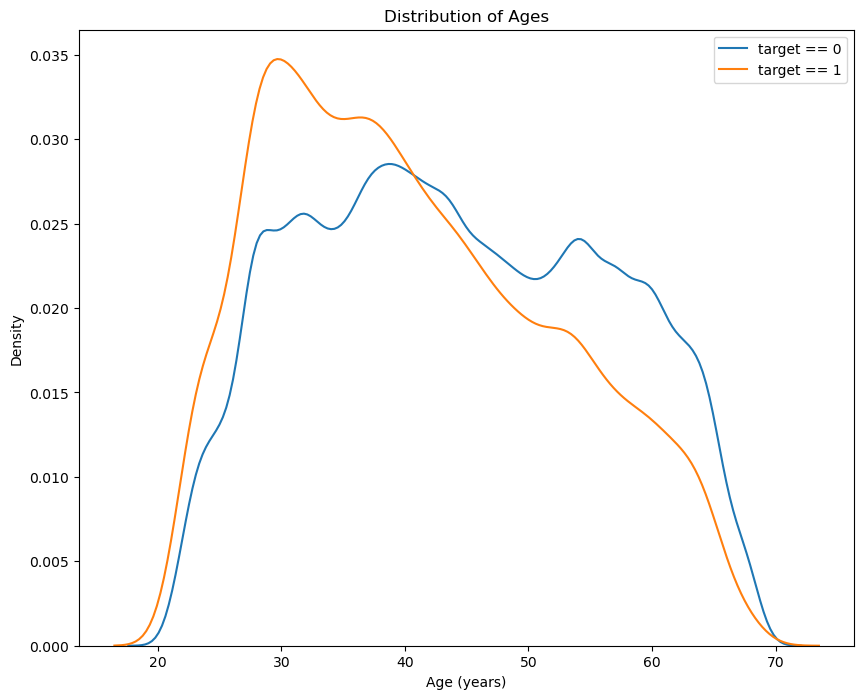

In [78]:
# Make Age positif value
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)') 
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()

As we can see, the target curve skews towards the younger people. Although this is not a significant correlation (-0.08 correlation coefficient), the fact it is not focus on certain group of people and the difference only little make this variable is likely going to be little useful in a machine learning model 

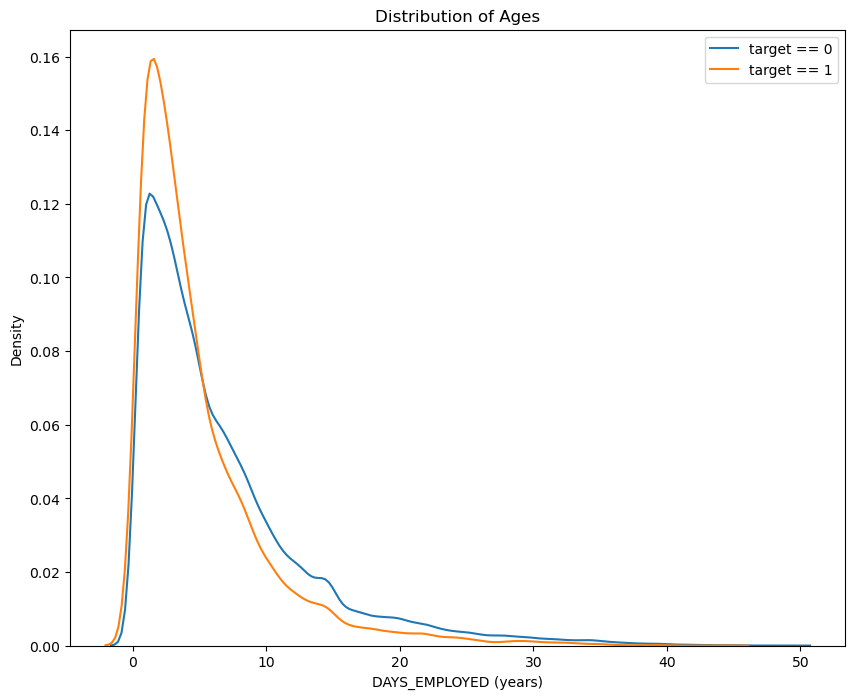

In [79]:
# Make DAYS_EMPLOYED positif value
app_train['DAYS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'])

plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_EMPLOYED'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_EMPLOYED'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('DAYS_EMPLOYED (years)') 
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()

from above chart we can see people who are long enough employed from current job(perspektif to application) are less likely to default.  althought, the correlation (0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target 

<Figure size 1000x800 with 0 Axes>

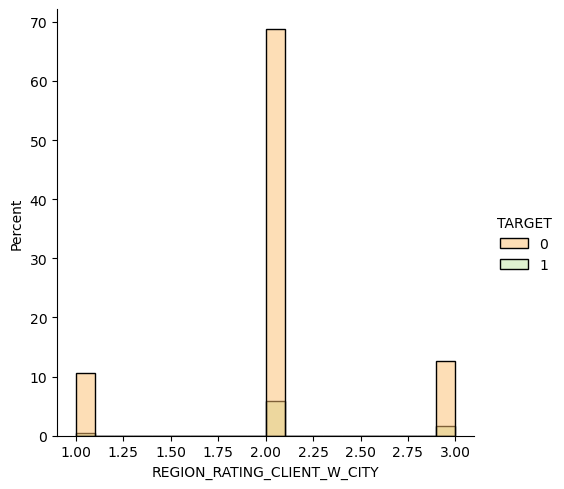

In [80]:
plt.figure(figsize = (10,8))
 
sns.displot(x='REGION_RATING_CLIENT_W_CITY', hue='TARGET', data=app_train, palette='Spectral',stat = 'percent')

from above chart we can see people who are live whitin region and city with score 2 likely to default.  althought, the correlation (0.06correlation coefficient), this variable is likely going to be little useful in a machine learning model because it does affect the target but not significant difference but other group.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source"

In [81]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

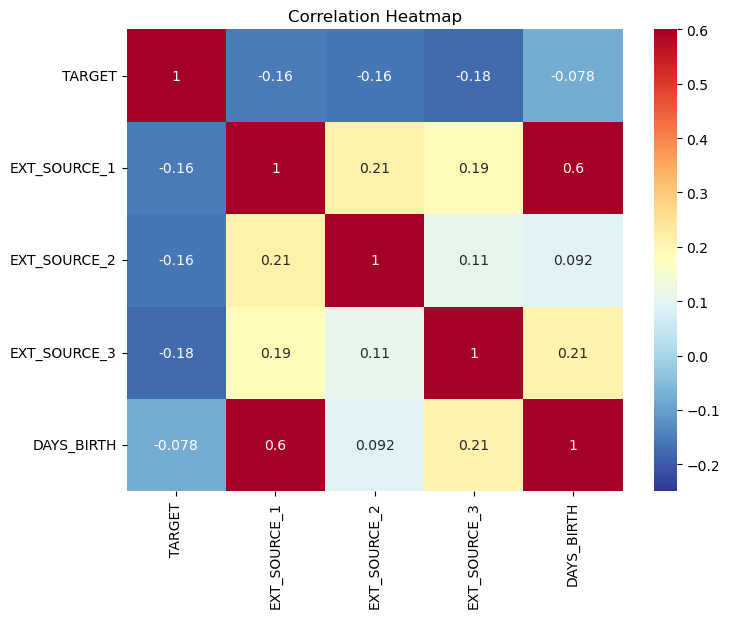

In [82]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

All three EXT_SOURCE featureshave negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

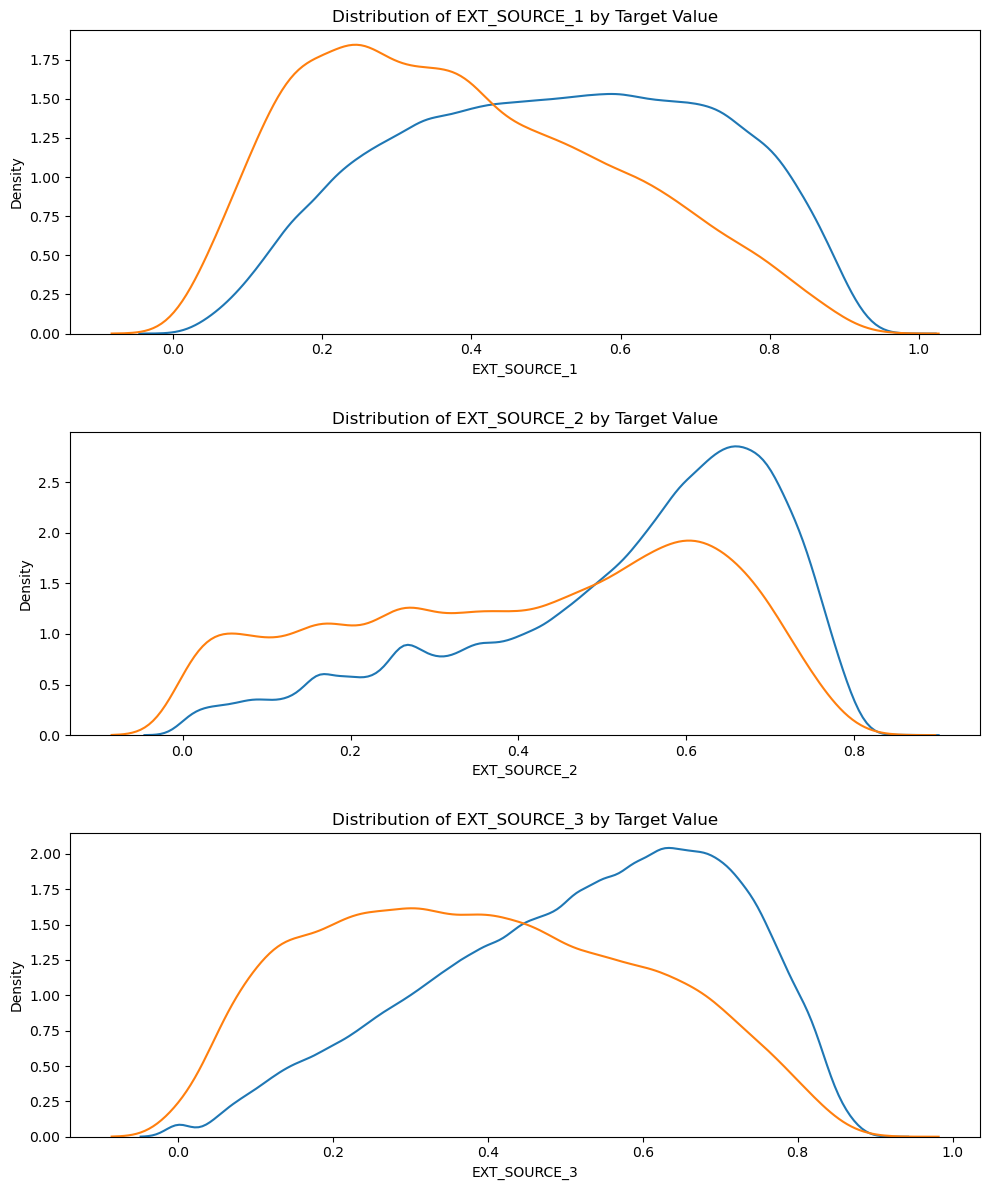

In [83]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source) 
    plt.ylabel('Density')
    
plt.tight_layout(h_pad = 2.5)
    

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the EXT_SOURCE_1 and the DAYS_BIRTH (or equivalently YEARS_BIRTH), indicating that this feature may take into account the age of the client.

# Feature Engineering

## Create new feature

I will try some create some feature domain knowladge i don't know if it is usefull but let's see in Machine Learning latter if our new feature help us build better score.
* `CREDIT_INCOME_PERCENT`= How many payment needed to fully complete payment if all income used to pay.
* `ANNUITY_INCOME_PERCENT`= Percentage of annuity againts total income.
* `CREDIT_TERM`= How many month needed to complete the payment.
* `DAYS_EMPLOYED_PERCENT`= The percentage of the days employed relative to the client's age.
* `INCOME_PER_PERC`= Average of income in 1 family

In [84]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_CREDIT']/app_train_domain['AMT_ANNUITY']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
app_train_domain['INCOME_PER_PERSON'] = app_train_domain['AMT_INCOME_TOTAL'] / app_train_domain['CNT_FAM_MEMBERS']

In [86]:
app_train['AMT_CREDIT']

0          406597.5
1         1293502.5
2          135000.0
3          312682.5
4          513000.0
            ...    
307506     254700.0
307507     269550.0
307508     677664.0
307509     370107.0
307510     675000.0
Name: AMT_CREDIT, Length: 307511, dtype: float64

I will try some create some feature domain knowladge i don't know if it is usefull but let's see in Machine Learning latter if our new feature help us build better score.
* `CREDIT_INCOME_PERCENT`= How many payment needed to fully complete payment if all income used to pay.
* `ANNUITY_INCOME_PERCENT`= Percentage of annuity againts total income.
* `CREDIT_TERM`= How many month needed to complete the payment.
* `DAYS_EMPLOYED_PERCENT`= The percentage of the days employed relative to the client's age.

In [87]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] =   app_test_domain['AMT_ANNUITY']/app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']
app_test_domain['INCOME_PER_PERSON'] = app_test_domain['AMT_INCOME_TOTAL'] / app_test_domain['CNT_FAM_MEMBERS']

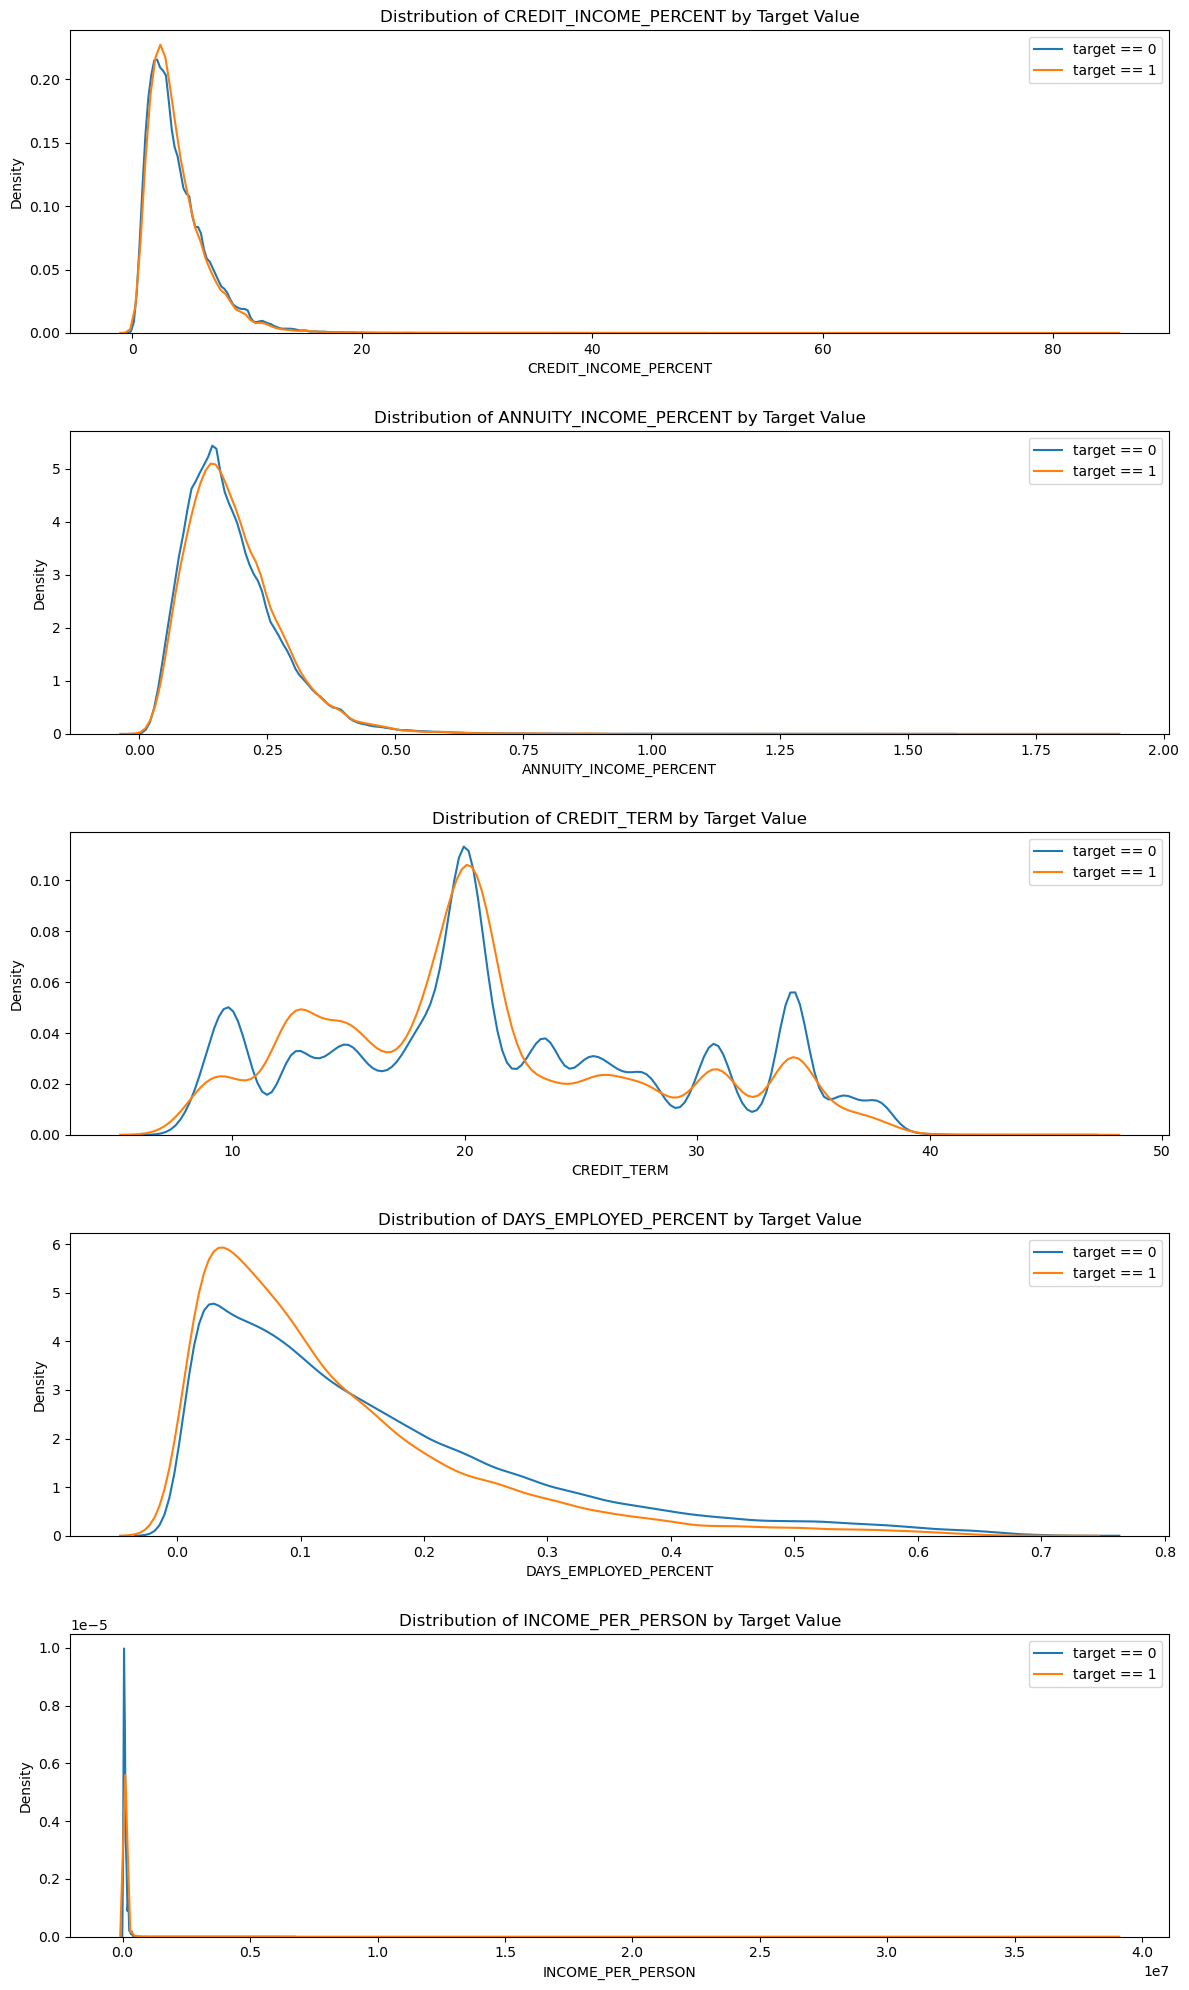

In [88]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT','INCOME_PER_PERSON']):
    
    # create a new subplot for each source
    plt.subplot(5, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

## Encoding

In [89]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [90]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 244)
Testing Features shape:  (48744, 240)


I noticed there are difference key columns between testing data and training data. we will remove the column from testing data we don't own at training data

In [91]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)



Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 240)


In [92]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 240)


## featured engineer column

In [93]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train_domain:
    if app_train_domain[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train_domain[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train_domain[col])
            # Transform both training and testing data
            app_train_domain[col] = le.transform(app_train_domain[col])
            app_test_domain[col] = le.transform(app_test_domain[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [94]:
train_labels= app_train_domain['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train_domain, app_test_domain = app_train_domain.align(app_test_domain, join = 'inner', axis = 1)

# Add the target back in
app_train_domain['TARGET'] = train_labels

print('Training Features shape: ', app_train_domain.shape)
print('Testing Features shape: ', app_test_domain.shape)

# one-hot encoding of categorical variables
app_train_domain = pd.get_dummies(app_train_domain)
app_test_domain = pd.get_dummies(app_test_domain)

print('Training Features shape: ', app_train_domain.shape)
print('Testing Features shape: ', app_test_domain.shape)

Training Features shape:  (307511, 128)
Testing Features shape:  (48744, 127)
Training Features shape:  (307511, 249)
Testing Features shape:  (48744, 245)


# Modeling

In [95]:

def eval_classification(model,X_train,X_test,y_train,y_test,x_val,y_val):
    ''' Function to plot and show score of model
    '''
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
    

    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred, zero_division=0))
    print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train, zero_division=0))
    

    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred, zero_division=0))
    print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train, zero_division=0))


    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred, zero_division=0))
    print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train, zero_division=0))


    print('Test score:' + str(model.score(X_test, y_test))) #Test score
    print('Train score: ' + str(model.score(X_train, y_train))) #Train score
    

    print("AUC (Test Set): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("AUC (Train Set): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

    conf_mat = confusion_matrix(y_test,y_pred)
    print(conf_mat)
    print('='*100)
    print()

In [97]:
# Drop the target from the training data
if 'TARGET' in app_train.columns:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()

if 'SK_ID_CURR' in app_train.columns:
    train = train.drop(columns = ['SK_ID_CURR'])
else:
    train = train.copy()

# split
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size=0.3, random_state=21)

# Feature names
features = list(X_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')
# Fit on the training data
imputer.fit(X_train)

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape: ', train.shape)

Training data shape:  (307511, 239)


### StratifiedKFold

In [54]:
#tranform into 1d array
y_train=np.array(y_train)
y_test=np.array(y_test)

#create dict models
model_dict={    
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(n_estimators=250,max_depth=12,min_samples_leaf=16),
    "XGBoost" : XGBClassifier(max_depth=12,
                              n_estimators=100,
                              min_child_weight=8, 
                              subsample=0.8, 
                              learning_rate =0.02,    
                              seed=42),
    "CatBoost" : CatBoostClassifier(iterations=100,
                           learning_rate=0.2,
                           od_type='Iter',
                           verbose=25,
                           depth=8,
                           random_seed=42),                            
    "LGB"       :LGBMClassifier(n_estimators=100, objective = 'binary', 
                            class_weight = 'balanced', learning_rate = 0.05, 
                            reg_alpha = 0.1, reg_lambda = 0.1, 
                            subsample = 0.8, n_jobs = -1, random_state = 50)
            }

#create stratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)
result_table = pd.DataFrame(columns=['classifiers','Kfold','accuracy','presicion','recall','f1_score','fpr','tpr','auc','conf_mat'])

for name,classifier in model_dict.items():
    print('start: %s' % name)
    for i,(train_index, test_index) in enumerate(skf.split(X_train,y_train)):
        print('Fold : %i' % i)
        x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        classifier.fit(x_train_fold, y_train_fold)

        y_predict=classifier.predict(x_test_fold)
        y_prob = classifier.predict_proba(x_test_fold)[::,1]
        
        fpr, tpr, _ = roc_curve(y_test_fold,y_prob)
        

        result_table = result_table.append({'classifiers': name,
                                    'Kfold': i,
                                    'accuracy':accuracy_score(y_test_fold, y_predict),
                                    'presicion':precision_score(y_test_fold, y_predict, average='weighted'),
                                    'recall':recall_score(y_test_fold, y_predict, average='weighted'),
                                    'f1_score':f1_score(y_test_fold, y_predict, average='weighted'),
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'auc':roc_auc_score(y_test_fold, y_prob),
                                    'conf_mat':confusion_matrix(y_test_fold,y_predict)

                                        }, ignore_index=True)
        
    

start: LogisticRegression
Fold : 0
Fold : 1
Fold : 2
Fold : 3
Fold : 4
start: KNeighbors
Fold : 0
Fold : 1
Fold : 2
Fold : 3
Fold : 4
start: DecisionTree
Fold : 0
Fold : 1
Fold : 2
Fold : 3
Fold : 4
start: RandomForest
Fold : 0
Fold : 1
Fold : 2
Fold : 3
Fold : 4
start: XGBoost
Fold : 0
Fold : 1
Fold : 2
Fold : 3
Fold : 4
start: CatBoost
Fold : 0
0:	learn: 0.5067890	total: 220ms	remaining: 21.7s
25:	learn: 0.2447904	total: 1.62s	remaining: 4.61s
50:	learn: 0.2389648	total: 2.99s	remaining: 2.88s
75:	learn: 0.2333248	total: 4.47s	remaining: 1.41s
99:	learn: 0.2283610	total: 5.8s	remaining: 0us
Fold : 1
0:	learn: 0.5109258	total: 51.9ms	remaining: 5.14s
25:	learn: 0.2446928	total: 1.47s	remaining: 4.19s
50:	learn: 0.2387291	total: 2.85s	remaining: 2.74s
75:	learn: 0.2338195	total: 4.29s	remaining: 1.36s
99:	learn: 0.2285268	total: 5.69s	remaining: 0us
Fold : 2
0:	learn: 0.5120387	total: 50.7ms	remaining: 5.02s
25:	learn: 0.2446523	total: 1.46s	remaining: 4.15s
50:	learn: 0.2395777	total:

In [81]:
score=result_table[['classifiers','Kfold','accuracy','presicion','recall','f1_score','auc']].sort_values('auc',ascending=False)
lgb_score=score[score.classifiers=='LGB'].reset_index(drop=True)
cb_score=score[score.classifiers=='CatBoost'].reset_index(drop=True)
lr_score=score[score.classifiers=='LogisticRegression'].reset_index(drop=True)
xgb_score=score[score.classifiers=='XGBoost'].reset_index(drop=True)
rf_score=score[score.classifiers=='RandomForest'].reset_index(drop=True)
knn_score=score[score.classifiers=='KNeighbors'].reset_index(drop=True)
dt_score=score[score.classifiers=='DecisionTree'].reset_index(drop=True)

score.drop(columns='Kfold',inplace=True)
mean_score=score.groupby('classifiers').mean()
mean_score.sort_values(by='recall').reset_index().sort_values(by='recall',ascending=False)



,classifiers,accuracy,presicion,recall,f1_score,auc
6,CatBoost,0.919454,0.890539,0.919454,0.883874,0.752508
5,XGBoost,0.919204,0.886643,0.919204,0.881597,0.739565
4,RandomForest,0.919180,0.844892,0.919180,0.880472,0.736806
3,LogisticRegression,0.919018,0.882259,0.919018,0.882001,0.743774
2,KNeighbors,0.914270,0.859530,0.914270,0.880346,0.549085
1,DecisionTree,0.851968,0.862144,0.851968,0.856945,0.538462
0,LGB,0.699355,0.896289,0.699355,0.766906,0.753195


observe 3 top models

In [82]:
cb_score

,classifiers,Kfold,accuracy,presicion,recall,f1_score,auc
0,CatBoost,2,0.919514,0.890934,0.919514,0.883846,0.755318
1,CatBoost,3,0.918933,0.883551,0.918933,0.883366,0.754853
2,CatBoost,1,0.919121,0.886072,0.919121,0.883656,0.753132
3,CatBoost,4,0.920072,0.899401,0.920072,0.884441,0.750267
4,CatBoost,0,0.919632,0.892735,0.919632,0.884058,0.748972


In [ ]:
xgb_score

In [ ]:
rf_score

## Hypertuning Parameter using hyper opt

## CatBoost

In [42]:
N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest

obj_call_count = 0
cur_best_loss = np.inf
log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

D_train = Pool(X_train, y_train)
D_test = Pool(X_test, y_test)

In [43]:
def get_catboost_params(space):
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    params['border_count'] = space['border_count']
    return params

In [146]:
def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = CatBoostClassifier(iterations=1000,
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        loss_function='Logloss',
                                        use_best_model=True,
                                        task_type="GPU",
                                        eval_metric='AUC',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=3000,
                                        od_type="Iter",
                                        border_count=int(params['border_count']),
                                        verbose=False
                                        )
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(D_test.get_features())
    test_loss = log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    acc = accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    auc = roc_auc_score(D_test.get_label(), y_pred[:,1])

    log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    log_writer.flush()

    if test_loss<cur_best_loss:
        cur_best_loss = test_loss
        print('NEW BEST LOSS={}'.format(cur_best_loss))


    return{'loss':test_loss, 'status': STATUS_OK }

In [147]:
space = {
        'depth': hp.quniform("depth", 1, 6, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.0001, 1.0),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
       }

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best )
print('\n\n')

                                                      
CatBoost objective call #204 cur_best_loss=0.24461
Params: border_count=64.73182158850207 depth=2.0 l2_leaf_reg=8.705511934433154 learning_rate=0.2938810537933632
  0%|          | 0/60 [00:00<?, ?trial/s, best loss=?]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=810                                          
                                                                                
CatBoost objective call #205 cur_best_loss=0.24461
Params: border_count=56.002506533490134 depth=2.0 l2_leaf_reg=7.184099599647285 learning_rate=0.5533737648457987
  2%|▏         | 1/60 [00:17<16:45, 17.04s/trial, best loss: 0.2454828283090572]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=357                                                                    
                                                                                
CatBoost objective call #206 cur_best_loss=0.24461
Params: border_count=47.916595962824644 depth=2.0 l2_leaf_reg=6.459654764435877 learning_rate=0.5268194598266517
  3%|▎         | 2/60 [00:33<16:16, 16.83s/trial, best loss: 0.2454828283090572]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=358                                                                    
                                                                                
CatBoost objective call #207 cur_best_loss=0.24461
Params: border_count=149.42795716290715 depth=6.0 l2_leaf_reg=3.5661983581635415 learning_rate=0.8691346001953045
  5%|▌         | 3/60 [00:50<15:58, 16.81s/trial, best loss: 0.2454828283090572]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=28                                                                     
                                                                                
CatBoost objective call #208 cur_best_loss=0.24461
Params: border_count=58.31774473217631 depth=2.0 l2_leaf_reg=3.381371009797519 learning_rate=0.9530215099481841
  7%|▋         | 4/60 [01:15<18:35, 19.92s/trial, best loss: 0.2454828283090572]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=270                                                                    
                                                                                
CatBoost objective call #209 cur_best_loss=0.24461
Params: border_count=225.8734685681727 depth=3.0 l2_leaf_reg=1.547707351879735 learning_rate=0.11564052207379358
  8%|▊         | 5/60 [01:31<17:07, 18.69s/trial, best loss: 0.2454828283090572]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=974                                                                    
                                                                                
CatBoost objective call #210 cur_best_loss=0.24461
Params: border_count=133.40335901530858 depth=5.0 l2_leaf_reg=5.393273621026943 learning_rate=0.12189526207095495
 10%|█         | 6/60 [01:50<16:52, 18.76s/trial, best loss: 0.2452780667446235]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=762                                                                    
                                                                                
CatBoost objective call #211 cur_best_loss=0.24461
Params: border_count=156.79411991556663 depth=2.0 l2_leaf_reg=7.817729010316089 learning_rate=0.8263568490074799
 12%|█▏        | 7/60 [02:12<17:31, 19.84s/trial, best loss: 0.2451815297132052]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=189                                                                    
                                                                                
CatBoost objective call #212 cur_best_loss=0.24461
Params: border_count=186.88069785612606 depth=3.0 l2_leaf_reg=1.3942340664191053 learning_rate=0.7092150892227955
 13%|█▎        | 8/60 [02:30<16:30, 19.05s/trial, best loss: 0.2451815297132052]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=147                                                                    
                                                                                
CatBoost objective call #213 cur_best_loss=0.24461
Params: border_count=242.06407340396683 depth=2.0 l2_leaf_reg=6.651814868024965 learning_rate=0.8783556087521817
 15%|█▌        | 9/60 [02:49<16:12, 19.07s/trial, best loss: 0.2451815297132052]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=178                                                                    
                                                                                 
CatBoost objective call #214 cur_best_loss=0.24461
Params: border_count=155.65477165461039 depth=6.0 l2_leaf_reg=3.5169578278935347 learning_rate=0.4032901107971493
 17%|█▋        | 10/60 [03:06<15:29, 18.60s/trial, best loss: 0.2451815297132052]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=99                                                                      
                                                                                 
CatBoost objective call #215 cur_best_loss=0.24461
Params: border_count=57.37298425293988 depth=5.0 l2_leaf_reg=7.972552412537252 learning_rate=0.7712544917282084
 18%|█▊        | 11/60 [03:31<16:45, 20.52s/trial, best loss: 0.2451815297132052]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=33                                                                      
                                                                                 
CatBoost objective call #216 cur_best_loss=0.24461
Params: border_count=83.72476927126922 depth=6.0 l2_leaf_reg=7.279942206049172 learning_rate=0.47134289634560467
 20%|██        | 12/60 [03:52<16:31, 20.67s/trial, best loss: 0.2451815297132052]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=67                                                                      
                                                                                 
CatBoost objective call #217 cur_best_loss=0.24461
Params: border_count=112.5642206333579 depth=3.0 l2_leaf_reg=7.29672803009 learning_rate=0.005309859631590545
 22%|██▏       | 13/60 [04:16<16:52, 21.55s/trial, best loss: 0.2451815297132052]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=1000                                                                    
                                                                                 
CatBoost objective call #218 cur_best_loss=0.24461
Params: border_count=192.31610834193984 depth=3.0 l2_leaf_reg=6.688081340509884 learning_rate=0.6950599296733571
 23%|██▎       | 14/60 [04:34<15:47, 20.60s/trial, best loss: 0.2451815297132052]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=156                                                                     
                                                                                 
CatBoost objective call #219 cur_best_loss=0.24461
Params: border_count=154.60853115271354 depth=4.0 l2_leaf_reg=3.155453432839101 learning_rate=0.6691083529470231
 25%|██▌       | 15/60 [04:53<15:01, 20.03s/trial, best loss: 0.2451815297132052]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=116                                                                     
                                                                                 
CatBoost objective call #220 cur_best_loss=0.24461
Params: border_count=34.564343842170075 depth=4.0 l2_leaf_reg=1.53493950560147 learning_rate=0.8839633408030603
 27%|██▋       | 16/60 [05:13<14:47, 20.17s/trial, best loss: 0.2451815297132052]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=45                                                                      
                                                                                 
CatBoost objective call #221 cur_best_loss=0.24461
Params: border_count=202.62473207172937 depth=2.0 l2_leaf_reg=5.9876376765917385 learning_rate=0.17585257509015317
 28%|██▊       | 17/60 [05:32<14:11, 19.80s/trial, best loss: 0.2451815297132052]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=999                                                                     
                                                                                  
CatBoost objective call #222 cur_best_loss=0.24461
Params: border_count=188.41705166528772 depth=2.0 l2_leaf_reg=9.916091010563644 learning_rate=0.8126108782454449
 30%|███       | 18/60 [05:50<13:26, 19.21s/trial, best loss: 0.24514375128576277]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=303                                                                      
                                                                                  
CatBoost objective call #223 cur_best_loss=0.24461
Params: border_count=243.2776606364785 depth=3.0 l2_leaf_reg=5.044424721437893 learning_rate=0.9231505496621611
 32%|███▏      | 19/60 [06:09<13:08, 19.23s/trial, best loss: 0.24514375128576277]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=49                                                                       
                                                                                  
CatBoost objective call #224 cur_best_loss=0.24461
Params: border_count=116.17194096655513 depth=1.0 l2_leaf_reg=5.128046506885064 learning_rate=0.18384398853962206
 33%|███▎      | 20/60 [06:30<13:07, 19.68s/trial, best loss: 0.24514375128576277]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=998                                                                      
                                                                                  
CatBoost objective call #225 cur_best_loss=0.24461
Params: border_count=210.94774745850128 depth=5.0 l2_leaf_reg=4.399303457936531 learning_rate=0.003916443320961027
 35%|███▌      | 21/60 [06:47<12:15, 18.85s/trial, best loss: 0.24514375128576277]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=1000                                                                     
                                                                                  
CatBoost objective call #226 cur_best_loss=0.24461
Params: border_count=121.17425357734338 depth=1.0 l2_leaf_reg=5.854628355689455 learning_rate=0.14672491034256444
 37%|███▋      | 22/60 [07:11<12:57, 20.47s/trial, best loss: 0.24514375128576277]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=998                                                                      
                                                                                  
CatBoost objective call #227 cur_best_loss=0.24461
Params: border_count=174.76122587090796 depth=5.0 l2_leaf_reg=4.430098233432103 learning_rate=0.25416502622190745
 38%|███▊      | 23/60 [07:28<11:59, 19.44s/trial, best loss: 0.24514375128576277]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=263                                                                      
                                                                                  
CatBoost objective call #228 cur_best_loss=0.24461
Params: border_count=131.68110007006777 depth=4.0 l2_leaf_reg=9.117804308230703 learning_rate=0.06690559498302592
 40%|████      | 24/60 [07:50<12:07, 20.20s/trial, best loss: 0.24514375128576277]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=998                                                                      
                                                                                  
CatBoost objective call #229 cur_best_loss=0.24461
Params: border_count=83.70761746214691 depth=4.0 l2_leaf_reg=9.970864223866574 learning_rate=0.04518699273145427
 42%|████▏     | 25/60 [08:11<11:53, 20.38s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=1000                                                                     
                                                                                  
CatBoost objective call #230 cur_best_loss=0.24461
Params: border_count=212.5437423733742 depth=4.0 l2_leaf_reg=8.718699927653278 learning_rate=0.3363621237304904
 43%|████▎     | 26/60 [08:31<11:30, 20.31s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=244                                                                      
                                                                                  
CatBoost objective call #231 cur_best_loss=0.24461
Params: border_count=97.1766423521491 depth=1.0 l2_leaf_reg=9.288402719214513 learning_rate=0.2400162310786153
 45%|████▌     | 27/60 [08:53<11:23, 20.71s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=998                                                                      
                                                                                  
CatBoost objective call #232 cur_best_loss=0.24461
Params: border_count=253.90605828386146 depth=4.0 l2_leaf_reg=8.922758547619976 learning_rate=0.3290416584641287
 47%|████▋     | 28/60 [09:10<10:26, 19.59s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=341                                                                      
                                                                                  
CatBoost objective call #233 cur_best_loss=0.24461
Params: border_count=134.95001511922828 depth=1.0 l2_leaf_reg=8.150135760788514 learning_rate=0.05811785362259772
 48%|████▊     | 29/60 [09:32<10:29, 20.31s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=998                                                                      
                                                                                  
CatBoost objective call #234 cur_best_loss=0.24461
Params: border_count=165.4245694297424 depth=3.0 l2_leaf_reg=5.996171897674129 learning_rate=0.441503436322721
 50%|█████     | 30/60 [09:50<09:51, 19.72s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=361                                                                      
                                                                                  
CatBoost objective call #235 cur_best_loss=0.24461
Params: border_count=209.61312436470894 depth=4.0 l2_leaf_reg=2.167930905917899 learning_rate=0.2160217143412227
 52%|█████▏    | 31/60 [10:11<09:42, 20.08s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=422                                                                      
                                                                                  
CatBoost objective call #236 cur_best_loss=0.24461
Params: border_count=171.0517751352551 depth=5.0 l2_leaf_reg=2.4424885232168143 learning_rate=0.37371469449530065
 53%|█████▎    | 32/60 [10:34<09:44, 20.89s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=188                                                                      
                                                                                  
CatBoost objective call #237 cur_best_loss=0.24461
Params: border_count=138.42739378511462 depth=2.0 l2_leaf_reg=9.502928552218119 learning_rate=0.5840255523817481
 55%|█████▌    | 33/60 [10:57<09:43, 21.63s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=450                                                                      
                                                                                  
CatBoost objective call #238 cur_best_loss=0.24461
Params: border_count=101.39734587561438 depth=3.0 l2_leaf_reg=4.570799641971766 learning_rate=0.07683867627394494
 57%|█████▋    | 34/60 [11:16<09:01, 20.84s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=976                                                                      
                                                                                  
CatBoost objective call #239 cur_best_loss=0.24461
Params: border_count=221.18867679565102 depth=1.0 l2_leaf_reg=4.009616357015138 learning_rate=0.2763864755003298
 58%|█████▊    | 35/60 [11:36<08:31, 20.46s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=1000                                                                     
                                                                                  
CatBoost objective call #240 cur_best_loss=0.24461
Params: border_count=75.82460263852266 depth=2.0 l2_leaf_reg=8.28960423139288 learning_rate=0.16774327826260688
 60%|██████    | 36/60 [11:53<07:50, 19.62s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=998                                                                      
                                                                                  
CatBoost objective call #241 cur_best_loss=0.24461
Params: border_count=198.84247071040372 depth=4.0 l2_leaf_reg=6.182962320391189 learning_rate=0.5725633655780915
 62%|██████▏   | 37/60 [12:13<07:30, 19.58s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=118                                                                      
                                                                                  
CatBoost objective call #242 cur_best_loss=0.24461
Params: border_count=128.18202095031924 depth=5.0 l2_leaf_reg=7.5598455403452105 learning_rate=0.12016616846454134
 63%|██████▎   | 38/60 [12:36<07:31, 20.52s/trial, best loss: 0.24499744147973254]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=725                                                                      
                                                                                  
CatBoost objective call #243 cur_best_loss=0.24461
Params: border_count=127.40983445360773 depth=6.0 l2_leaf_reg=7.5631894706173926 learning_rate=0.995219751895915
 65%|██████▌   | 39/60 [12:59<07:29, 21.42s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=17                                                                       
                                                                                  
CatBoost objective call #244 cur_best_loss=0.24461
Params: border_count=144.93547904459203 depth=5.0 l2_leaf_reg=6.8808111183174745 learning_rate=0.09614534131448664
 67%|██████▋   | 40/60 [13:26<07:38, 22.92s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=946                                                                      
                                                                                  
CatBoost objective call #245 cur_best_loss=0.24461
Params: border_count=43.16654685445573 depth=6.0 l2_leaf_reg=6.737535978790481 learning_rate=0.5239758380717057
 68%|██████▊   | 41/60 [13:51<07:29, 23.67s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=51                                                                       
                                                                                  
CatBoost objective call #246 cur_best_loss=0.24461
Params: border_count=147.8295521094832 depth=5.0 l2_leaf_reg=6.983498584274446 learning_rate=0.10976143773513282
 70%|███████   | 42/60 [14:17<07:20, 24.49s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=916                                                                      
                                                                                  
CatBoost objective call #247 cur_best_loss=0.24461
Params: border_count=176.23992448717664 depth=5.0 l2_leaf_reg=8.548372320981885 learning_rate=0.0013270203631338962
 72%|███████▏  | 43/60 [14:43<07:04, 24.96s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=1000                                                                     
                                                                                  
CatBoost objective call #248 cur_best_loss=0.24461
Params: border_count=96.77086754743414 depth=6.0 l2_leaf_reg=7.718863871693466 learning_rate=0.3040010503468761
 73%|███████▎  | 44/60 [15:11<06:50, 25.66s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=114                                                                      
                                                                                  
CatBoost objective call #249 cur_best_loss=0.24461
Params: border_count=103.49441983689388 depth=6.0 l2_leaf_reg=5.643787287513959 learning_rate=0.6151575300327382
 75%|███████▌  | 45/60 [15:38<06:34, 26.28s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=36                                                                       
                                                                                  
CatBoost objective call #250 cur_best_loss=0.24461
Params: border_count=68.26530417489371 depth=5.0 l2_leaf_reg=7.09147516418389 learning_rate=0.38787677978339674
 77%|███████▋  | 46/60 [16:06<06:13, 26.71s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=187                                                                      
                                                                                  
CatBoost objective call #251 cur_best_loss=0.24461
Params: border_count=145.05250828716382 depth=5.0 l2_leaf_reg=9.628779157146212 learning_rate=0.4285645032352947
 78%|███████▊  | 47/60 [16:32<05:44, 26.50s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=107                                                                      
                                                                                  
CatBoost objective call #252 cur_best_loss=0.24461
Params: border_count=161.4868905125553 depth=6.0 l2_leaf_reg=6.525138859958423 learning_rate=0.4971222556894021
 80%|████████  | 48/60 [16:59<05:17, 26.48s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=58                                                                       
                                                                                  
CatBoost objective call #253 cur_best_loss=0.24461
Params: border_count=111.44981562684681 depth=5.0 l2_leaf_reg=5.331668233790442 learning_rate=0.11143612802559999
 82%|████████▏ | 49/60 [17:28<05:02, 27.48s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=798                                                                      
                                                                                  
CatBoost objective call #254 cur_best_loss=0.24461
Params: border_count=182.13898178990794 depth=6.0 l2_leaf_reg=7.579605518866432 learning_rate=0.03221516480642128
 83%|████████▎ | 50/60 [17:55<04:32, 27.28s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=1000                                                                     
                                                                                  
CatBoost objective call #255 cur_best_loss=0.24461
Params: border_count=84.03113144025173 depth=5.0 l2_leaf_reg=6.322817056581677 learning_rate=0.1948376791324759
 85%|████████▌ | 51/60 [18:23<04:07, 27.50s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=407                                                                      
                                                                                  
CatBoost objective call #256 cur_best_loss=0.24461
Params: border_count=124.69171979701454 depth=6.0 l2_leaf_reg=8.4571940120014 learning_rate=0.13684681506813814
 87%|████████▋ | 52/60 [18:50<03:38, 27.33s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=431                                                                      
                                                                                  
CatBoost objective call #257 cur_best_loss=0.24461
Params: border_count=62.743697224014355 depth=5.0 l2_leaf_reg=3.1350664030720035 learning_rate=0.35773677752860933
 88%|████████▊ | 53/60 [19:25<03:27, 29.66s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=113                                                                      
                                                                                  
CatBoost objective call #258 cur_best_loss=0.24461
Params: border_count=152.06896518478214 depth=4.0 l2_leaf_reg=7.992761781204513 learning_rate=0.28807451075196344
 90%|█████████ | 54/60 [19:51<02:51, 28.54s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=431                                                                      
                                                                                  
CatBoost objective call #259 cur_best_loss=0.24461
Params: border_count=230.076308029156 depth=5.0 l2_leaf_reg=4.774655107902609 learning_rate=0.22609933286500156
 92%|█████████▏| 55/60 [20:17<02:19, 27.83s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=331                                                                      
                                                                                  
CatBoost objective call #260 cur_best_loss=0.24461
Params: border_count=48.6243289711817 depth=6.0 l2_leaf_reg=3.765663292805957 learning_rate=0.7636046590982927
 93%|█████████▎| 56/60 [20:44<01:49, 27.35s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=24                                                                       
                                                                                  
CatBoost objective call #261 cur_best_loss=0.24461
Params: border_count=111.65928739766568 depth=3.0 l2_leaf_reg=7.33720606561066 learning_rate=0.10517544873819087
 95%|█████████▌| 57/60 [21:11<01:22, 27.36s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=983                                                                      
                                                                                  
CatBoost objective call #262 cur_best_loss=0.24461
Params: border_count=195.98445681111565 depth=4.0 l2_leaf_reg=6.755567140613742 learning_rate=0.6624924346318997
 97%|█████████▋| 58/60 [21:33<00:51, 25.73s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=92                                                                       
                                                                                  
CatBoost objective call #263 cur_best_loss=0.24461
Params: border_count=141.4490354359506 depth=6.0 l2_leaf_reg=9.005899028316414 learning_rate=0.02273175952670363
 98%|█████████▊| 59/60 [21:57<00:25, 25.14s/trial, best loss: 0.24478823180259632]

Default metric period is 5 because AUC is/are not implemented for GPU


nb_trees=996                                                                      
100%|██████████| 60/60 [22:26<00:00, 22.43s/trial, best loss: 0.24478823180259632]
--------------------------------------------------
The best params:
{'border_count': 128.18202095031924, 'depth': 5.0, 'l2_leaf_reg': 7.5598455403452105, 'learning_rate': 0.12016616846454134}





In [148]:
print(best)

{'border_count': 128.18202095031924, 'depth': 5.0, 'l2_leaf_reg': 7.5598455403452105, 'learning_rate': 0.12016616846454134}


In [149]:
best.update({'border_count': int(best['border_count'])})
best

{'border_count': 128,
 'depth': 5.0,
 'l2_leaf_reg': 7.5598455403452105,
 'learning_rate': 0.12016616846454134}

In [150]:
model = CatBoostClassifier(iterations=20000,
                                    loss_function='Logloss',
                                    use_best_model=True,
                                    task_type="GPU",
                                    eval_metric='AUC',
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    verbose=2000,
                                    **best
                                    )

model.fit(D_train, eval_set=D_test, verbose=2000)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6766659	best: 0.6766659 (0)	total: 21.2ms	remaining: 7m 4s
bestTest = 0.7611197531
bestIteration = 930
Shrink model to first 931 iterations.


In [ ]:
pred = model.predict_proba(D_test.get_features())
print("auc = ", roc_auc_score(D_test.get_label(), pred[:,1]))
print("acc = ", accuracy_score(D_test.get_label(), np.argmax(pred, axis=1)))
print("loss = ",log_loss(D_test.get_label(), pred, labels=[0, 1]))

auc =  0.7588362152123094
acc =  0.919927591215557
loss =  0.24542286888216666


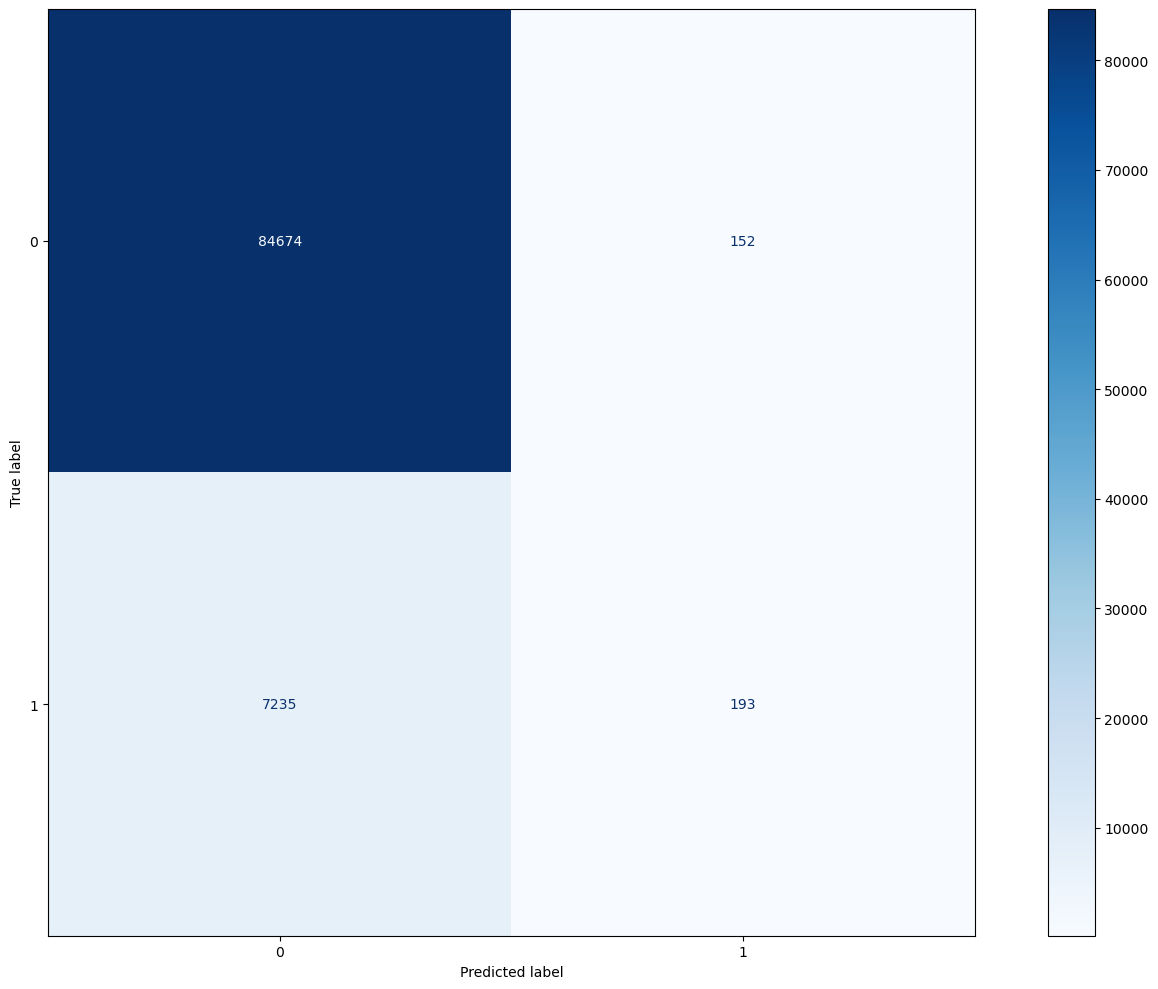

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
plot_confusion_matrix(model, 
                          X_test,
                          y_test, 
                          ax=axes, 
                          cmap='Blues')
#axes.title.set_text('random_forest')
plt.tight_layout()  
plt.show()

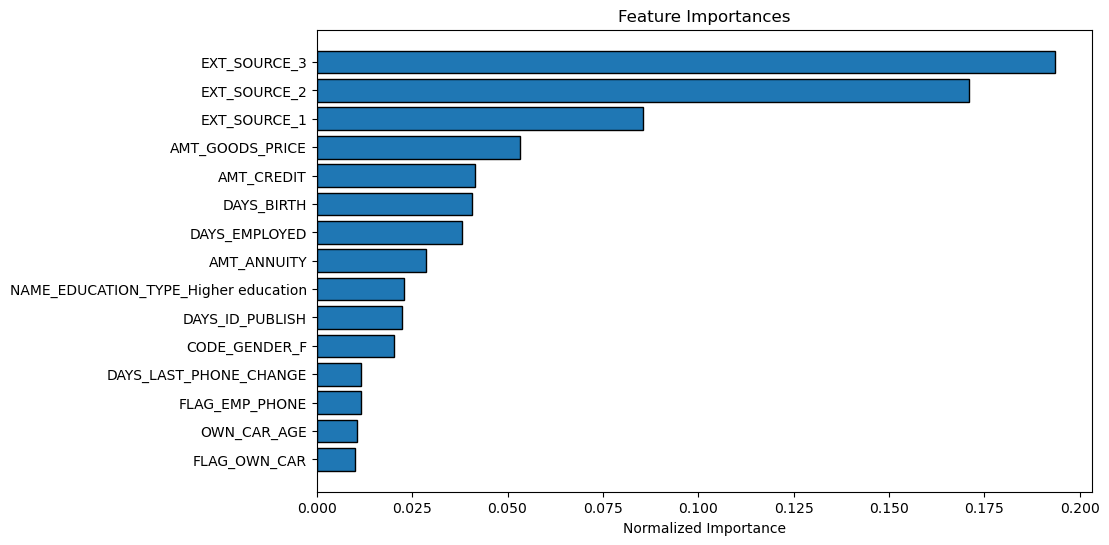

In [112]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
plot_feature_importances(feature_importances)